In [2]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence
import ot #Optimal Transport


## Import functions for the experiment : 

from experiment_functions import *


dans un premier temps, à la zeub on prend une fonction de mapping connue, et on essaye de sample la posteriori sachant que la prior est une gaussian mixture classique 25 modes. 

Paramètres de la prior -> centres équirépartis entre -16 et 16. Unit variance et équipondérée

### Setting of the Experiment 

In this experiment, we will try to estimate the Maximum Marginal Likelihood with the Interacting Particle Langevin Algorithm (IPLA), as in the article : (...). But here we will try to improve / accelerate the sampling with the Dilation Path from the paper : (...). 

In this example, we take as a prior Distribution a Gaussian Mixture with 25 modes, whose parameters are defined bellow. Here is the statistical model that, we suppose, describes the relationship between x and y : (...). 

In [88]:
#We define the grid

x = np.linspace(-16, 16, 5)
y = np.linspace(-16, 16, 5)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances = np.array([[[1, 0], [0, 1]]]*25)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(25) / 25


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

##Dimensions des variables

dx = 2

dy = 1

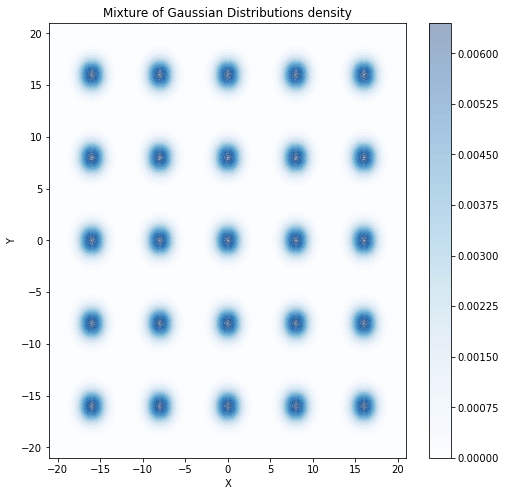

In [17]:
generate_multimodal(centers, covariances, weights)

100%|██████████| 15000/15000 [01:55<00:00, 130.05it/s]


The magnitude of the Stochastic term is 0.11466210804553721 whereas the magnitude of the gradient term is 0.00999998910124191
 Voici le step moyen sur toutes les particles 0.005009914913630025, et voici le time moyen auquel on est sur la simu 75.14872370445036


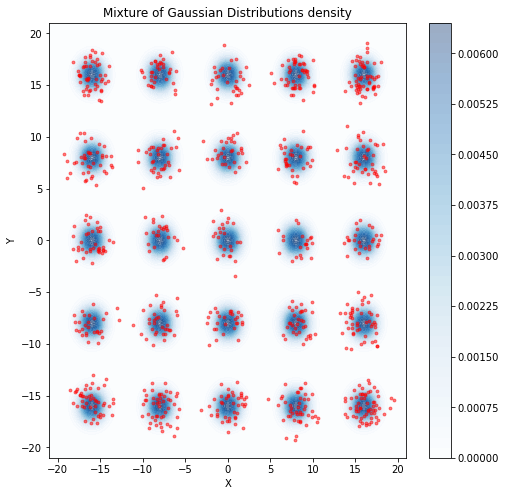

In [37]:
x = ULA_dilation(sample_init, 15000, weights, centers, covariances, 0.1, 50, alpha = 0.01, vector_result=True)

Then, we have to define the other parameters of the experiment : $H$, $y$ and $\sigma_y$, as in the paper. We are able to plot the density of the "true" posterior distribution $p(x sachant y) $. 

Aucun sens la génération de l'opérateur H dans l'article qui pue la beuteu. Pb de dimension

In [158]:
Id = np.eye(2)
s_i_j = np.random.uniform(0, 1, 25)
s_i_j.reshape((5, 5))
H_tilde = np.random.randn(1, 2)
U, Sigma, Vt = np.linalg.svd(H_tilde, full_matrices=False)

In [242]:
H = np.array([0.5, 0.1])
#H = U[0] * np.eye(2) * s_i_j[:, np.newaxis] @ Vt.T
Sigma = np.linalg.inv(Id + 10000 * np.outer(H.T, H)) #Le petit delta est chelouuuuu
sigma_y = 0.1
H, Sigma

(array([0.5, 0.1]),
 array([[ 0.03883122, -0.19223376],
        [-0.19223376,  0.96155325]]))

Génération y comme dans l'article : 

First, we draw $x^{*}$ according to the prior distribution. And then, y = ...

On tire UN SEUL x* juste pour générer l'unique observations mais par la suite on aura plusieurs X qui seront les particules de l'algo. 

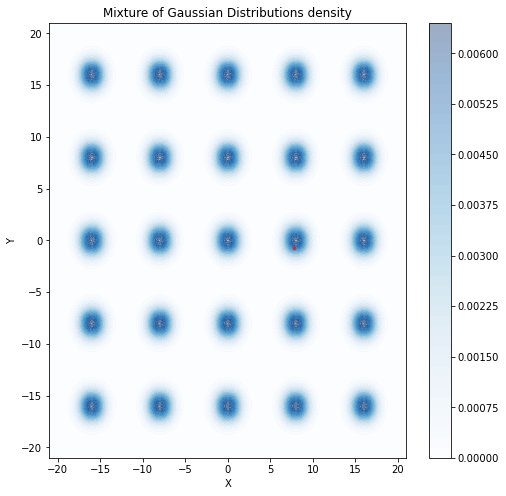

In [243]:
nb_particle_gen = 1
nb_components = len(weights)
x_star = np.zeros((nb_particle_gen, 2))

# Selection of the component randomly
component_choices = np.random.choice(nb_components, size=nb_particle_gen, p=weights) #choix aléatoire entre les normales de la mixture (pondéré)

for i in range(nb_components):

    num_samples = np.sum(component_choices == i) #

    if num_samples > 0:

        x_star[component_choices == i] = np.random.multivariate_normal(mean=centers[i], cov=covariances[i], size=num_samples) #pour les indices où l'on a tiré la composante en question on tire selon celle-ci

generate_multimodal(centers, covariances, weights, x_star)

In [244]:
noise = np.random.normal(0, sigma_y**2)
y_obs = H @ x_star.T + noise
y_obs

array([3.78335157])

In [245]:
centers_posteriori = np.zeros((25, 2)) 

for i in range(25): 
        
        centers_posteriori[i] = Sigma @ (H * (y_obs / (sigma_y ** 2)) + centers[i])

centers_posteriori[0]

array([  2.52716939, -12.29456612])

In [246]:
covariances_posteriori = np.full((25, 2, 2), Sigma)
covariances_posteriori[0] 

array([[ 0.03883122, -0.19223376],
       [-0.19223376,  0.96155325]])

In [247]:
weights_posteriori = np.zeros(25)

for i in range(25): 

    mean = H @ centers[i].T
    covariance = 10000 + H.T @ H  ## A vérifier avec l'Appendix de l'article que ça soit bien en dim 1 # LE DELTA EST CHELOU NON IL VIENT DOU ? 
    weights_posteriori[i] = weights[i] * norm.pdf(y_obs, mean, covariance)

weights_posteriori = weights_posteriori / np.sum(weights_posteriori)
weights_posteriori

array([0.03999997, 0.03999999, 0.04      , 0.04000001, 0.04000001,
       0.03999998, 0.03999999, 0.04000001, 0.04000001, 0.04000001,
       0.03999998, 0.04      , 0.04000001, 0.04000001, 0.04000001,
       0.03999999, 0.04      , 0.04000001, 0.04000001, 0.04      ,
       0.03999999, 0.04      , 0.04000001, 0.04000001, 0.04      ])

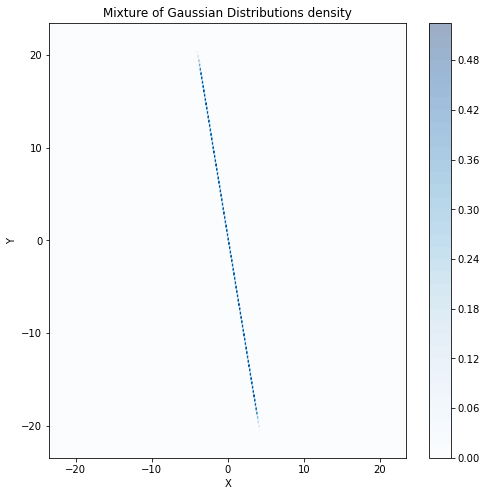

In [250]:
generate_multimodal(centers_posteriori, covariances_posteriori, weights_posteriori)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 1000/1000 [00:09<00:00, 106.37it/s]


The magnitude of the Stochastic term is 0.0041097878661386835 whereas the magnitude of the gradient term is 0.01499999999990884
 Voici le step moyen sur toutes les particles 0.0020089741889682913, et voici le time moyen auquel on est sur la simu 2.008974188968291


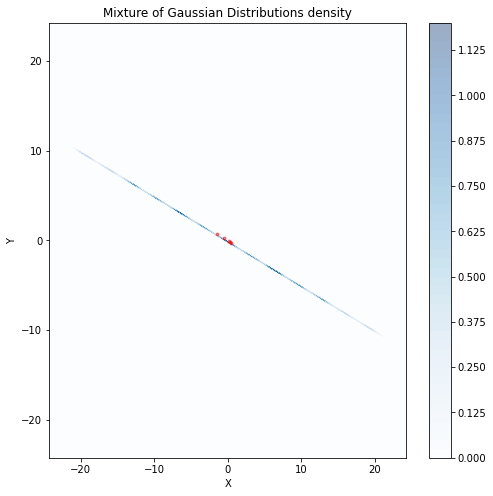

In [241]:
ULA_dilation(sample_init, 1000, weights_posteriori, centers_posteriori, covariances_posteriori, 2, 100, alpha = 0.015)